In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

import matplotlib.pyplot as plt
import cv2
import math
from PIL import Image

import tensorflow as tf #this is loading tensorflow
from tensorflow.keras import utils,Sequential,layers
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Reshape, LeakyReLU, Dropout, UpSampling2D # Bring in the layers for the neural network
from tensorflow import keras as ks

## EDA

First, we have to determine the paths were our image data is located and have a look at how many images we are working with.

In [2]:
monet_jpeg_path = '../input/gan-getting-started/monet_jpg/'

In [3]:
len_monet_jpeg = len(os.listdir(monet_jpeg_path))
len_monet_jpeg

300

In [4]:
monet_tfrec_path = '../input/gan-getting-started/monet_tfrec/'

In [5]:
len_monet_tfrec = len(os.listdir(monet_tfrec_path))
len_monet_tfrec

5

In [6]:
photo_jpeg_path = '../input/gan-getting-started/photo_jpg/'

In [7]:
len_photo_jpeg = len(os.listdir(photo_jpeg_path))
len_photo_jpeg

7038

In [8]:
photo_tfrec_path = '../input/gan-getting-started/photo_tfrec/'

In [9]:
len_photo_tfrec = len(os.listdir(photo_tfrec_path))
len_photo_tfrec

20

Now, let's display some example images, both monet and real photos.

In [10]:
def display_sample_images(path,start, num_samples):
    sample_images = os.listdir(path)[start:start+num_samples]
    
    w = int(num_samples ** .5)
    h = math.ceil(num_samples / w)
    
    for ind, image_name in enumerate(sample_images):
        img = cv2.imread(os.path.join(path, image_name))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
        plt.subplot(h, w, ind + 1)
        plt.imshow(img)
        plt.axis("off")
    
    plt.show()

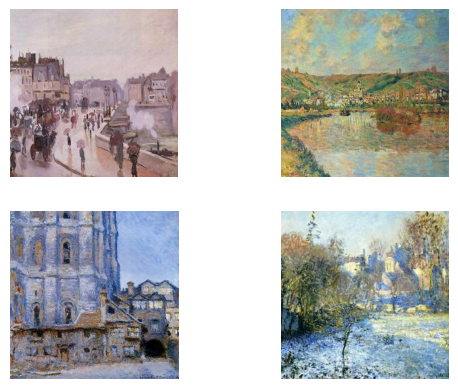

In [11]:
display_sample_images(monet_jpeg_path,25,4)

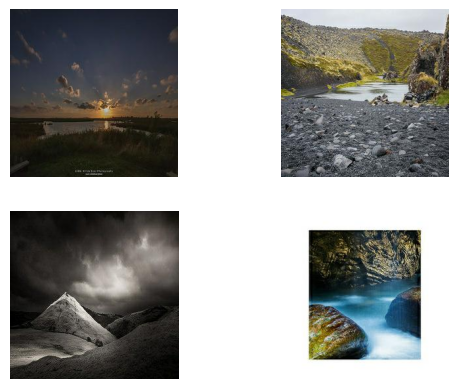

In [12]:
display_sample_images(photo_jpeg_path,35,4)

As we can see monet paintings have that distinctive style that many of us instantly relate to the famous painter called Monet. The photos on the other hand seem to be taken with a normal camera. Both types of images are colored ones, not just black and white.

We can verify the stated image sizes from the kaggle description by inspecting the width and height of both the monet paintings as well as the real photos.

In [13]:
for image_filename in os.listdir(monet_jpeg_path)[:10]:
        print(Image.open(os.path.join(monet_jpeg_path, image_filename)).size)

(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)


As we can see in the histograms all images are indeed of size 256x256 pixels. Next, we will have a look at how the different color channels are distributed in the images.

In [14]:
def display_color_channels(path):
    plt.figure(figsize=(16, 4))
    
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
    plt.subplot(1, 4, 1)
    plt.imshow(img)
    plt.axis("off")
    
    colors = ["red", "green", "blue"]
    for i in range(len(colors)):
        plt.subplot(1, 4, i + 2)
        plt.hist(
            img[:, :, i].reshape(-1),
            bins=50,
            color=colors[i],
            density=True
        )
        plt.xlim(0, 255)
        plt.xticks([])
        plt.yticks([])
     
    plt.show()

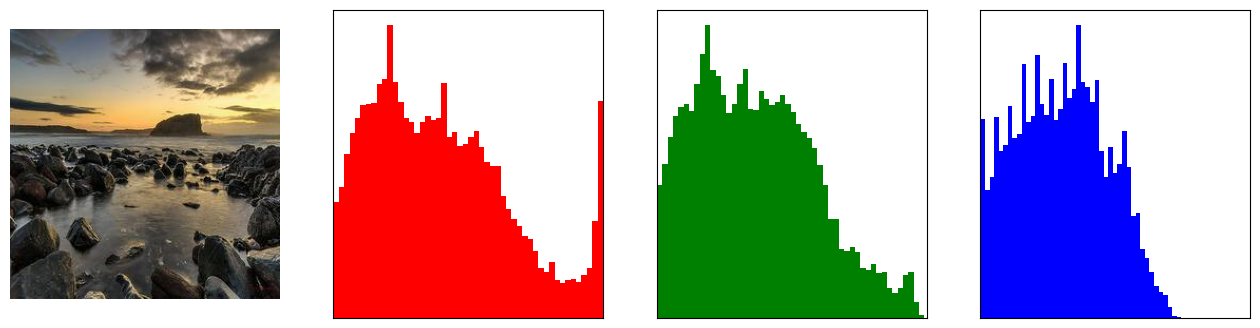

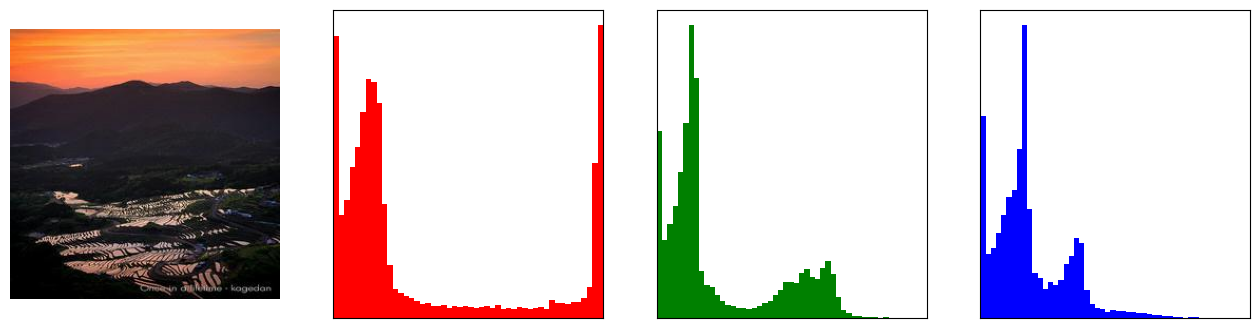

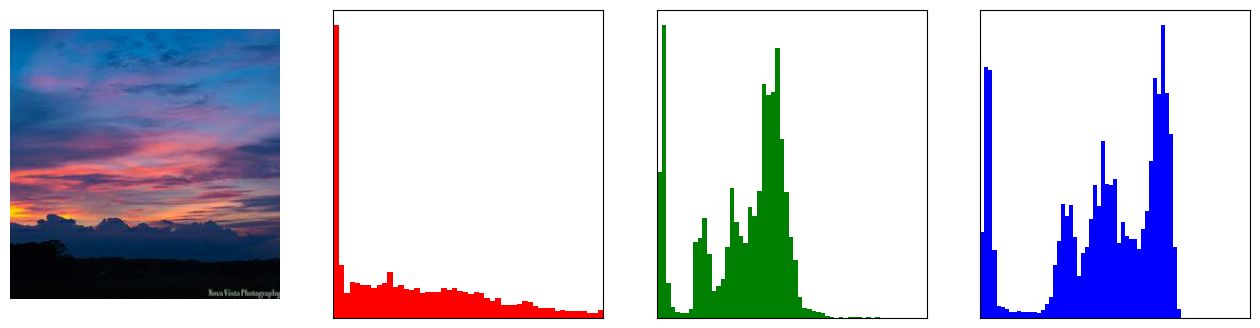

In [15]:
display_color_channels(photo_jpeg_path + os.listdir(photo_jpeg_path)[50])
display_color_channels(photo_jpeg_path + os.listdir(photo_jpeg_path)[105])
display_color_channels(photo_jpeg_path + os.listdir(photo_jpeg_path)[269])

The below plots show the color channels for three monet paintings respectively photos. We could now ask the question if a certain color channel is more present in the monet paintings than in the photos

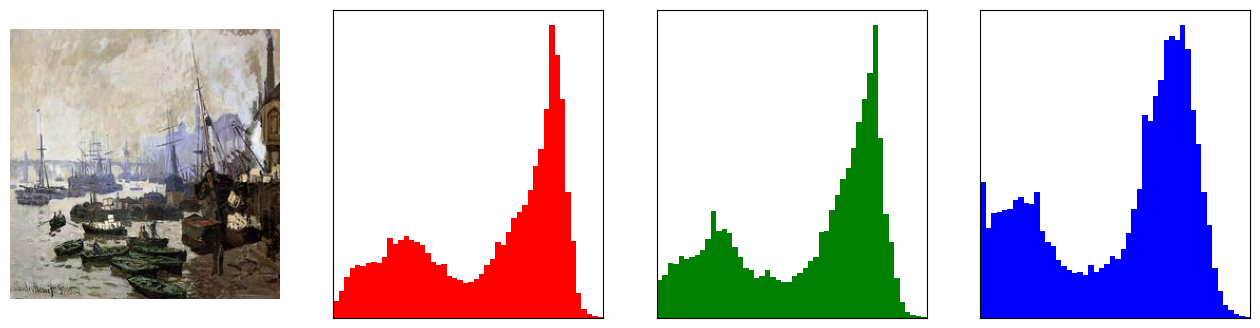

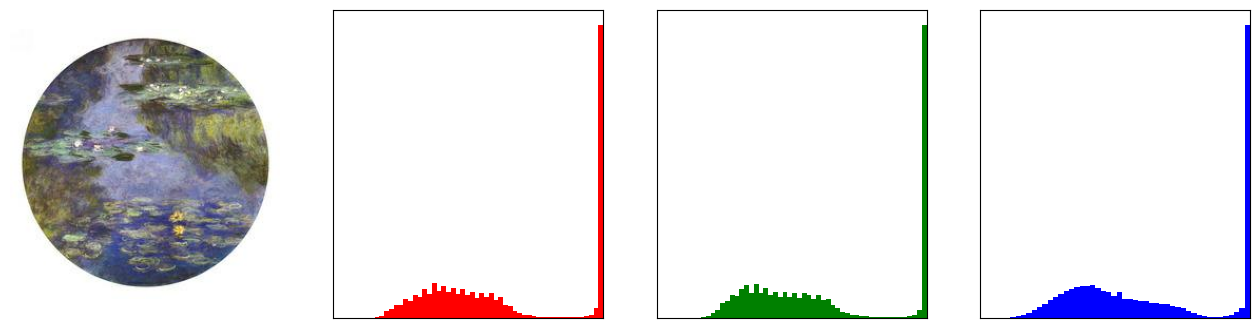

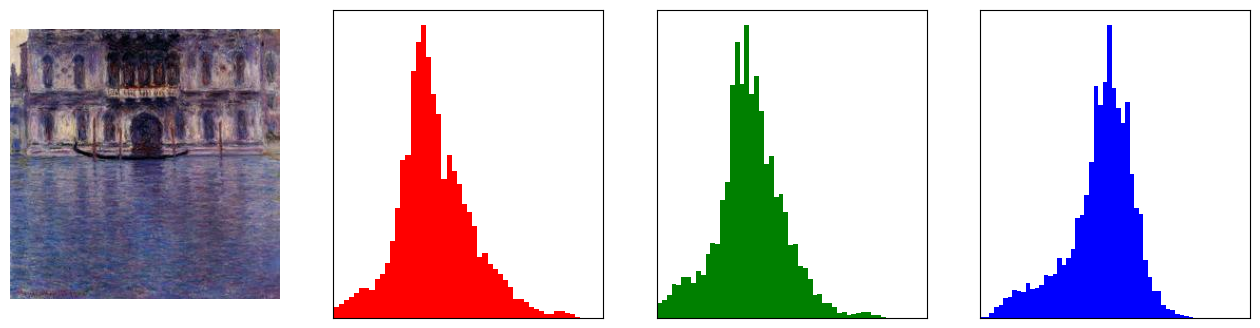

In [16]:
display_color_channels(monet_jpeg_path + os.listdir(monet_jpeg_path)[50])
display_color_channels(monet_jpeg_path + os.listdir(monet_jpeg_path)[105])
display_color_channels(monet_jpeg_path + os.listdir(monet_jpeg_path)[269])

## Model Building

In [17]:
import tensorflow_addons as tfa
from tensorflow import keras
from kaggle_datasets import KaggleDatasets

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

AUTOTUNE = tf.data.experimental.AUTOTUNE
    
print(tf.__version__)

Number of replicas: 1
2.13.0


/opt/conda/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [18]:
GCS_PATH = KaggleDatasets().get_gcs_path()

In [19]:
MONET_FILENAMES = tf.io.gfile.glob(str(GCS_PATH + '/monet_tfrec/*.tfrec'))
print('Monet TFRecord Files:', len(MONET_FILENAMES))

PHOTO_FILENAMES = tf.io.gfile.glob(str(GCS_PATH + '/photo_tfrec/*.tfrec'))
print('Photo TFRecord Files:', len(PHOTO_FILENAMES))

Monet TFRecord Files: 5
Photo TFRecord Files: 20


In [20]:
IMAGE_SIZE = [256, 256]

def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    return image

def read_tfrecord(example):
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    return image

In [21]:
def load_dataset(filenames, labeled=True, ordered=False):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTOTUNE)
    return dataset

In [22]:
monet_ds = load_dataset(MONET_FILENAMES, labeled=True).batch(2, drop_remainder=True).cache()
photo_ds = load_dataset(PHOTO_FILENAMES, labeled=True).batch(2, drop_remainder=True).cache()

In [23]:
example_monet = next(iter(monet_ds))
example_photo = next(iter(photo_ds))

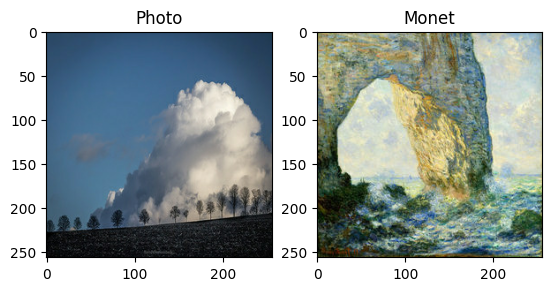

In [24]:
plt.subplot(121)
plt.title('Photo')
plt.imshow(example_photo[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Monet')
plt.imshow(example_monet[0] * 0.5 + 0.5)

We'll be using a UNET architecture for our CycleGAN. To build our generator, let's first define our downsample and upsample methods.

The downsample, as the name suggests, reduces the 2D dimensions, the width and height, of the image by the stride. The stride is the length of the step the filter takes. Since the stride is 2, the filter is applied to every other pixel, hence reducing the weight and height by 2.

We'll be using an instance normalization instead of batch normalization. As the instance normalization is not standard in the TensorFlow API, we'll use the layer from TensorFlow Add-ons.

In [25]:
OUTPUT_CHANNELS = 3

def downsample(filters, size, apply_instancenorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = keras.Sequential()
    result.add(layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

    if apply_instancenorm:
        result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))

    result.add(layers.LeakyReLU())

    return result

Upsample does the opposite of downsample and increases the dimensions of the of the image. Conv2DTranspose does basically the opposite of a Conv2D layer.

In [26]:
def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = keras.Sequential()
    result.add(layers.Conv2DTranspose(filters, size, strides=2,
                                      padding='same',
                                      kernel_initializer=initializer,
                                      use_bias=False))

    result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))

    if apply_dropout:
        result.add(layers.Dropout(0.5))

    result.add(layers.ReLU())

    return result

Let's build our generator!

The generator first downsamples the input image and then upsample while establishing long skip connections. Skip connections are a way to help bypass the vanishing gradient problem by concatenating the output of a layer to multiple layers instead of only one. Here we concatenate the output of the downsample layer to the upsample layer in a symmetrical fashion.

In [27]:
def Generator():
    inputs = layers.Input(shape=[256,256,3])

    # bs = batch size
    down_stack = [
        downsample(64, 4, apply_instancenorm=False), # (bs, 128, 128, 64)
        downsample(128,4), # (bs, 64, 64, 128)
        downsample(256, 4), # (bs, 32, 32, 256)
        downsample(512, 4), # (bs, 16, 16, 512)
        downsample(512, 4), # (bs, 8, 8, 512)
        downsample(512, 4), # (bs, 4, 4, 512)
        downsample(512, 4), # (bs, 2, 2, 512)
        downsample(512, 4), # (bs, 1, 1, 512)

    ]

    up_stack = [
        upsample(512, 4, apply_dropout=True), # (bs, 2, 2, 1024)
        upsample(512, 4, apply_dropout=True), # (bs, 4, 4, 1024)
        upsample(512, 4, apply_dropout=True), # (bs, 8, 8, 1024)
        upsample(512, 4), # (bs, 16, 16, 1024)
        upsample(256, 4), # (bs, 32, 32, 512)
        upsample(128, 4), # (bs, 64, 64, 256)
        upsample(64, 4), # (bs, 128, 128, 128)
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                  strides=2,
                                  padding='same',
                                  kernel_initializer=initializer,
                                  activation='tanh') # (bs, 256, 256, 3)

    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = layers.Concatenate()([x, skip])

    x = last(x)

    return keras.Model(inputs=inputs, outputs=x)

The discriminator takes in the input image and classifies it as real or fake (generated). Instead of outputing a single node, the discriminator outputs a smaller 2D image with higher pixel values indicating a real classification and lower values indicating a fake classification.

In [28]:
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    inp = layers.Input(shape=[256, 256, 3], name='input_image')

    x = inp

    down1 = downsample(64, 4, False)(x) # (bs, 128, 128, 64)
    down2 = downsample(128, 4)(down1) # (bs, 64, 64, 128)
    down3 = downsample(256, 4)(down2) # (bs, 32, 32, 256)

    zero_pad1 = layers.ZeroPadding2D()(down3) # (bs, 34, 34, 256)
    conv = layers.Conv2D(512, 4, strides=1,
                         kernel_initializer=initializer,
                         use_bias=False)(zero_pad1) # (bs, 31, 31, 512)

    norm1 = tfa.layers.InstanceNormalization(gamma_initializer=gamma_init)(conv)

    leaky_relu = layers.LeakyReLU()(norm1)

    zero_pad2 = layers.ZeroPadding2D()(leaky_relu) # (bs, 33, 33, 512)

    last = layers.Conv2D(1, 4, strides=1,
                         kernel_initializer=initializer)(zero_pad2) # (bs, 30, 30, 1)

    return tf.keras.Model(inputs=inp, outputs=last)

In [29]:
with strategy.scope():
    
    monet_generator = Generator() # transforms photos to Monet-esque paintings
    photo_generator = Generator() # transforms Monet paintings to be more like photos

    monet_discriminator = Discriminator() # differentiates real Monet paintings and generated Monet paintings
    photo_discriminator = Discriminator() # differentiates real photos and generated photos

Since our generators are not trained yet, the generated Monet-esque photo does not show what is expected at this point.

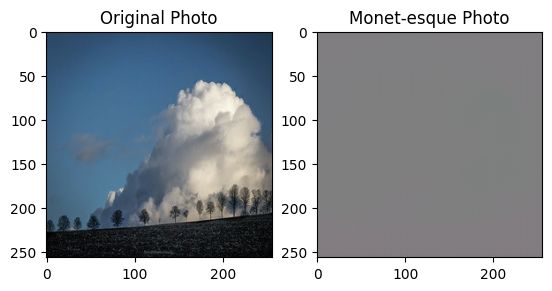

In [30]:
to_monet = monet_generator(example_photo)

plt.subplot(1, 2, 1)
plt.title("Original Photo")
plt.imshow(example_photo[0] * 0.5 + 0.5)

plt.subplot(1, 2, 2)
plt.title("Monet-esque Photo")
plt.imshow(to_monet[0] * 0.5 + 0.5)
plt.show()

We will subclass a tf.keras.Model so that we can run fit() later to train our model. During the training step, the model transforms a photo to a Monet painting and then back to a photo. The difference between the original photo and the twice-transformed photo is the cycle-consistency loss. We want the original photo and the twice-transformed photo to be similar to one another.

The losses are defined in the next section.

In [31]:
class CycleGan(keras.Model):
    def __init__(
        self,
        monet_generator,
        photo_generator,
        monet_discriminator,
        photo_discriminator,
        lambda_cycle=10,
    ):
        super(CycleGan, self).__init__()
        self.m_gen = monet_generator
        self.p_gen = photo_generator
        self.m_disc = monet_discriminator
        self.p_disc = photo_discriminator
        self.lambda_cycle = lambda_cycle
        
    def compile(
        self,
        m_gen_optimizer,
        p_gen_optimizer,
        m_disc_optimizer,
        p_disc_optimizer,
        gen_loss_fn,
        disc_loss_fn,
        cycle_loss_fn,
        identity_loss_fn
    ):
        super(CycleGan, self).compile()
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn
        
    def train_step(self, batch_data):
        real_monet, real_photo = batch_data
        
        with tf.GradientTape(persistent=True) as tape:
            # photo to monet back to photo
            fake_monet = self.m_gen(real_photo, training=True)
            cycled_photo = self.p_gen(fake_monet, training=True)

            # monet to photo back to monet
            fake_photo = self.p_gen(real_monet, training=True)
            cycled_monet = self.m_gen(fake_photo, training=True)

            # generating itself
            same_monet = self.m_gen(real_monet, training=True)
            same_photo = self.p_gen(real_photo, training=True)

            # discriminator used to check, inputing real images
            disc_real_monet = self.m_disc(real_monet, training=True)
            disc_real_photo = self.p_disc(real_photo, training=True)

            # discriminator used to check, inputing fake images
            disc_fake_monet = self.m_disc(fake_monet, training=True)
            disc_fake_photo = self.p_disc(fake_photo, training=True)

            # evaluates generator loss
            monet_gen_loss = self.gen_loss_fn(disc_fake_monet)
            photo_gen_loss = self.gen_loss_fn(disc_fake_photo)

            # evaluates total cycle consistency loss
            total_cycle_loss = self.cycle_loss_fn(real_monet, cycled_monet, self.lambda_cycle) + self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)

            # evaluates total generator loss
            total_monet_gen_loss = monet_gen_loss + total_cycle_loss + self.identity_loss_fn(real_monet, same_monet, self.lambda_cycle)
            total_photo_gen_loss = photo_gen_loss + total_cycle_loss + self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle)

            # evaluates discriminator loss
            monet_disc_loss = self.disc_loss_fn(disc_real_monet, disc_fake_monet)
            photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)

        # Calculate the gradients for generator and discriminator
        monet_generator_gradients = tape.gradient(total_monet_gen_loss,
                                                  self.m_gen.trainable_variables)
        photo_generator_gradients = tape.gradient(total_photo_gen_loss,
                                                  self.p_gen.trainable_variables)

        monet_discriminator_gradients = tape.gradient(monet_disc_loss,
                                                      self.m_disc.trainable_variables)
        photo_discriminator_gradients = tape.gradient(photo_disc_loss,
                                                      self.p_disc.trainable_variables)

        # Apply the gradients to the optimizer
        self.m_gen_optimizer.apply_gradients(zip(monet_generator_gradients,
                                                 self.m_gen.trainable_variables))

        self.p_gen_optimizer.apply_gradients(zip(photo_generator_gradients,
                                                 self.p_gen.trainable_variables))

        self.m_disc_optimizer.apply_gradients(zip(monet_discriminator_gradients,
                                                  self.m_disc.trainable_variables))

        self.p_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients,
                                                  self.p_disc.trainable_variables))
        
        return {
            "monet_gen_loss": total_monet_gen_loss,
            "photo_gen_loss": total_photo_gen_loss,
            "monet_disc_loss": monet_disc_loss,
            "photo_disc_loss": photo_disc_loss,
            "total_cycle_loss": total_cycle_loss

        }

In [32]:
class GANMonitor(keras.callbacks.Callback):
    """A callback to generate and save images after each epoch"""

    def __init__(self, num_img=4):
        self.num_img = num_img

    def on_epoch_end(self, epoch, logs=None):
        _, ax = plt.subplots(4, 2, figsize=(12, 12))
        for i, img in enumerate(photo_ds.take(self.num_img)):
            prediction = self.model.m_gen(img)[0].numpy()
            prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
            img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

            ax[i, 0].imshow(img)
            ax[i, 1].imshow(prediction)
            ax[i, 0].set_title("Input image")
            ax[i, 1].set_title("Translated image")
            ax[i, 0].axis("off")
            ax[i, 1].axis("off")

#             prediction = keras.preprocessing.image.array_to_img(prediction)
#             prediction.save(
#                 "generated_img_{i}_{epoch}.png".format(i=i, epoch=epoch + 1)
#             )
        plt.show()
        plt.close()

The discriminator loss function below compares real images to a matrix of 1s and fake images to a matrix of 0s. The perfect discriminator will output all 1s for real images and all 0s for fake images. The discriminator loss outputs the average of the real and generated loss.

In [33]:
with strategy.scope():
    def discriminator_loss(real, generated):
        real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(real), real)

        generated_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.zeros_like(generated), generated)

        total_disc_loss = real_loss + generated_loss

        return total_disc_loss * 0.5

The generator wants to fool the discriminator into thinking the generated image is real. The perfect generator will have the discriminator output only 1s. Thus, it compares the generated image to a matrix of 1s to find the loss.

In [34]:
with strategy.scope():
    def generator_loss(generated):
        return tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(generated), generated)

In [35]:
with strategy.scope():
    def calc_cycle_loss(real_image, cycled_image, LAMBDA):
        loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

        return LAMBDA * loss1

We want our original photo and the twice transformed photo to be similar to one another. Thus, we can calculate the cycle consistency loss be finding the average of their difference.

In [36]:
with strategy.scope():
    def identity_loss(real_image, same_image, LAMBDA):
        loss = tf.reduce_mean(tf.abs(real_image - same_image))
        return LAMBDA * 0.5 * loss

In [37]:
with strategy.scope():
    monet_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

    monet_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

The identity loss compares the image with its generator (i.e. photo with photo generator). If given a photo as input, we want it to generate the same image as the image was originally a photo. The identity loss compares the input with the output of the generator.

In [38]:
with strategy.scope():
    cycle_gan_model = CycleGan(
        monet_generator, photo_generator, monet_discriminator, photo_discriminator
    )

    cycle_gan_model.compile(
        m_gen_optimizer = monet_generator_optimizer,
        p_gen_optimizer = photo_generator_optimizer,
        m_disc_optimizer = monet_discriminator_optimizer,
        p_disc_optimizer = photo_discriminator_optimizer,
        gen_loss_fn = generator_loss,
        disc_loss_fn = discriminator_loss,
        cycle_loss_fn = calc_cycle_loss,
        identity_loss_fn = identity_loss
    )
    plotter = GANMonitor()
checkpoint_filepath = "./model_checkpoints/cyclegan_checkpoints.{epoch:03d}"
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath
)

    150/Unknown - 1429s 9s/step - monet_gen_loss: 6.2397 - photo_gen_loss: 6.4915 - monet_disc_loss: 0.6185 - photo_disc_loss: 0.5776 - total_cycle_loss: 4.5501

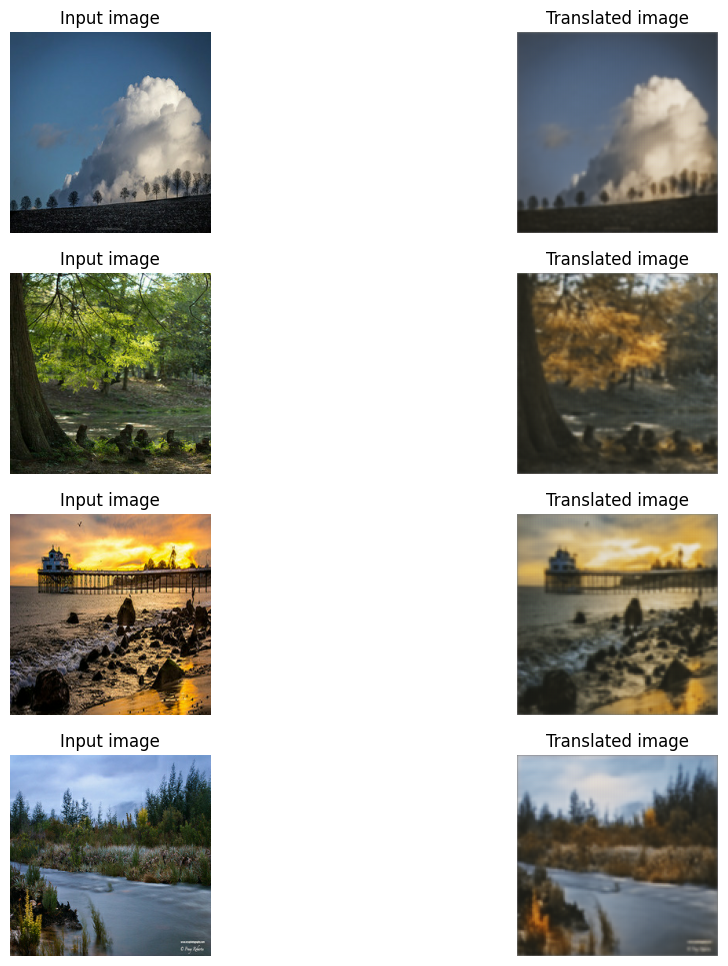

150/150 [==============================] - 1436s 9s/step - monet_gen_loss: 6.2243 - photo_gen_loss: 6.4789 - monet_disc_loss: 0.6191 - photo_disc_loss: 0.5764 - total_cycle_loss: 4.5385


In [39]:
cycle_gan_model.fit(
    tf.data.Dataset.zip((monet_ds, photo_ds)),
    epochs=1,
    callbacks=[plotter],
)

## Visualize Monet-esque pictures

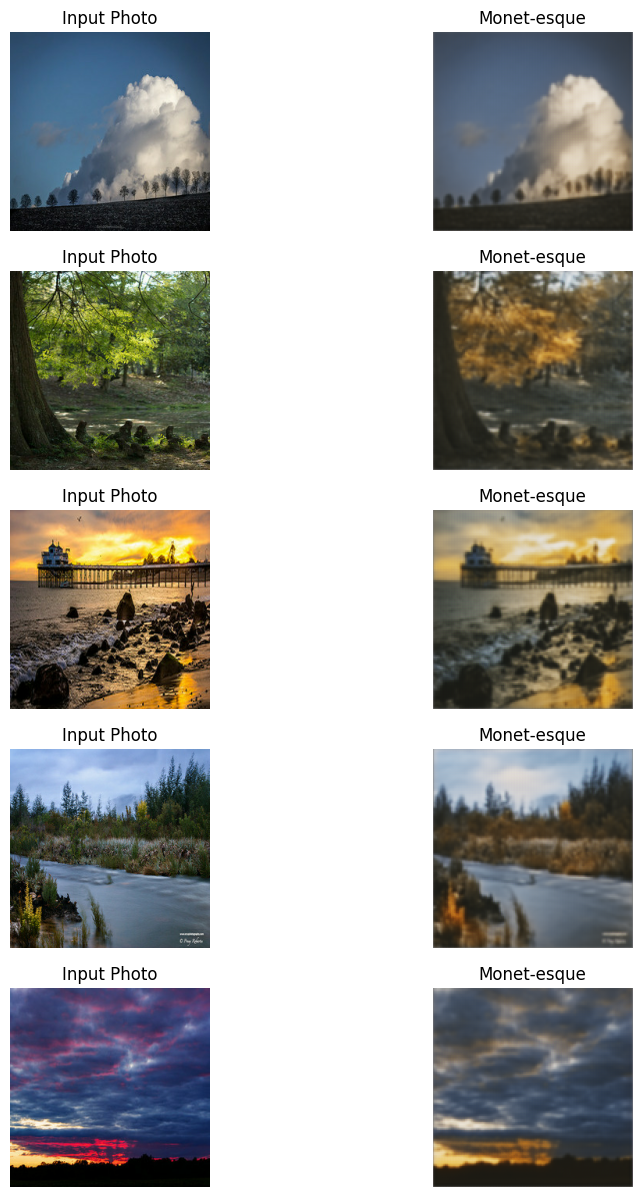

In [40]:
_, ax = plt.subplots(5, 2, figsize=(10, 15))
for i, img in enumerate(photo_ds.take(5)):
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title("Input Photo")
    ax[i, 1].set_title("Monet-esque")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
plt.show()

In [41]:
import PIL
! mkdir ../images

In [42]:
photo_ds1 = load_dataset(PHOTO_FILENAMES, labeled=True).batch(1, drop_remainder=True).cache()

In [43]:
i = 1
for img in photo_ds1:
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    im = PIL.Image.fromarray(prediction)
    im.save("../images/" + str(i) + ".jpg")
    i += 1

In [44]:
import shutil
shutil.make_archive("/kaggle/working/images", 'zip', "/kaggle/images")

'/kaggle/working/images.zip'

## Results and Conclusion

My MiFID Score was 98.1487. and 74 on the leaderboard of the competition

My model was and the pictures were too heavy for my computer to run the codes so, I had to do some adjustments while running the code

1. I processed all pictures, but I trained the model with batch of 2
2. I trained the model with only 1 Epoch because I tried 75 but i noticed it was taking forever to process only one epoch. Even 3 was taking more than 1h to run
3. I didn't do a tuning model to improve the model because only by increasing the number of epoches, I could have improved my results. tunning the model would take me too long to run

If I would have had the process structure to run the model I wanted with the tuning, I was pretty confident in reach lass the 10 in MiFID